# Демонстрация. Стратификация

In [2]:
import numpy as np
import pandas as pd
from typing import Optional, List
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from operator import attrgetter
from scipy.stats import ttest_ind, pearsonr, gamma
import random

## Сегментация 
### 1. Генерация данных

In [4]:
np.random.seed(100)

In [5]:
avg_order_value = gamma.rvs(4, size=10000) * 200

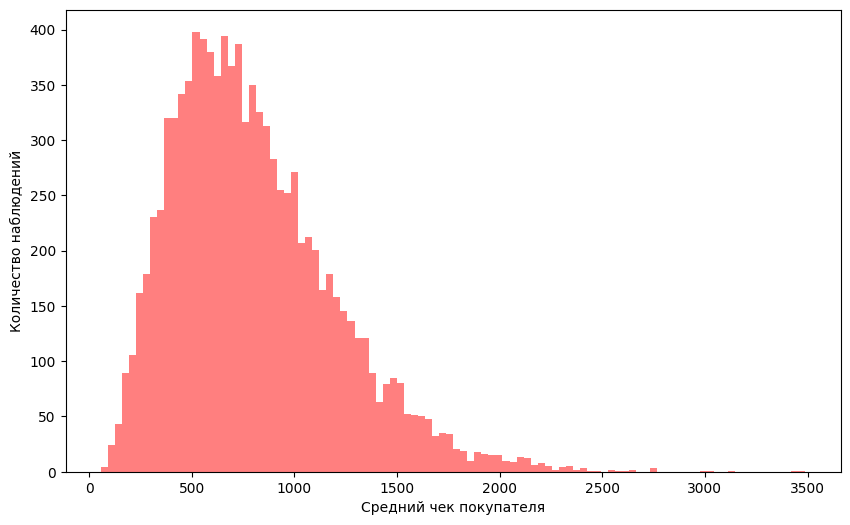

In [6]:
fig, ax = plt.subplots()
plt.hist(avg_order_value, bins=100, alpha=0.5, color='red')
ax.set_xlabel('Средний чек покупателя')
ax.set_ylabel('Количество наблюдений')
fig.set_figheight(6)
fig.set_figwidth(10)
plt.show()

### 2. Биннинг переменной 

In [8]:
df = pd.DataFrame(avg_order_value, columns = ['avg_order_value'])
df['grp_avg_order_value'] = pd.qcut(df['avg_order_value'], 5)

In [9]:
# Интервалы бинов
np.unique(df['grp_avg_order_value'])

array([Interval(56.505, 462.219, closed='right'),
       Interval(462.219, 644.663, closed='right'),
       Interval(644.663, 838.031, closed='right'),
       Interval(838.031, 1107.065, closed='right'),
       Interval(1107.065, 3489.747, closed='right')], dtype=object)

In [10]:
# Границы бинов
bins_bound = list(np.unique(df['grp_avg_order_value'].map(attrgetter('left'))))
bins_bound

[np.float64(56.505),
 np.float64(462.219),
 np.float64(644.663),
 np.float64(838.031),
 np.float64(1107.065)]

### 3. Визуализация биннинга

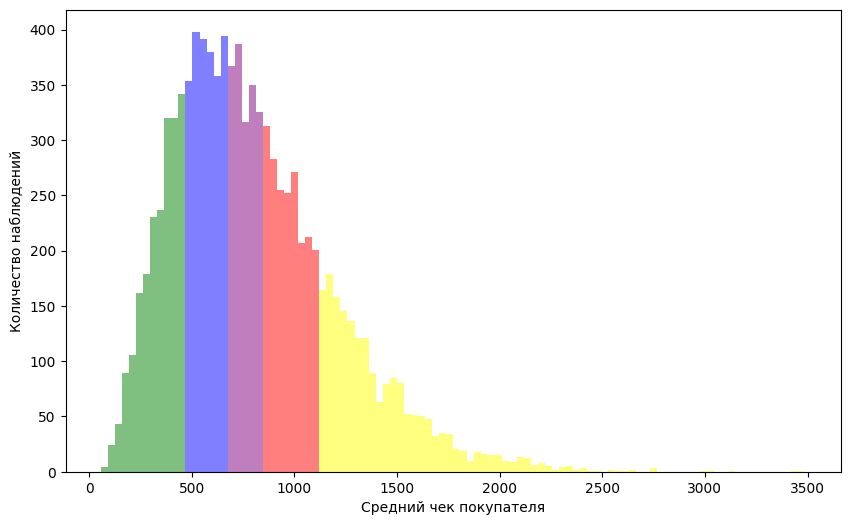

In [12]:
fig, ax = plt.subplots()
N, bins, patches = plt.hist(avg_order_value, alpha = 0.5, bins = 100)

for c, p in zip(bins, patches):
    if c >= bins_bound[0] and c < bins_bound[1]:
        plt.setp(p, 'facecolor', 'green')
    elif c >=  bins_bound[1] and c < bins_bound[2] :
        plt.setp(p, 'facecolor', 'blue')
    elif c >=  bins_bound[2] and c < bins_bound[3] :
        plt.setp(p, 'facecolor', 'purple')  
    elif c >=  bins_bound[3] and c < bins_bound[4] :
        plt.setp(p, 'facecolor', 'red')  
    else:
        plt.setp(p, 'facecolor', 'yellow')
    
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_xlabel('Средний чек покупателя')
ax.set_ylabel('Количество наблюдений')
plt.show()

### 4. Валидация сегментации

In [14]:
def stratified_samples(data, metric, strat_var, bins, n_obs, random_state=None):
    A_group = []
    B_group = []
    
    # количество наблюдений для обеих групп из каждого бина
    n = int(n_obs / len(bins) * 2)
    for i in bins:
        # выборка наблюдений размером n
        data_sample = data[data[strat_var] == i].sample(n, random_state = random_state).reset_index(drop=True)
        
        # рандомное разделение выборки на 2 рандомные группы
        indices = np.random.permutation(data_sample.shape[0])
        A_idx, B_idx = indices[:int(n/2)], indices[int(n/2):]
        A_sample, B_sample =  data_sample.iloc[A_idx, 0], data_sample.iloc[B_idx, 0]
        
        # объединение наблюдений из текущего бина к наблюдениям из предыдущих бинов
        A_group = np.hstack([A_group, np.array(A_sample)])
        B_group = np.hstack([B_group, np.array(B_sample)])
        
    return A_group, B_group

In [15]:
def random_samples(data, metric, n_obs, random_state=None):
    # выборка наблюдений размером n
    data_sample = data.sample(n_obs * 2, random_state=random_state).reset_index(drop=True)
    
    # рандомное разделение выборки на 2 рандомные группы
    indices = np.random.permutation(data_sample.shape[0])
    A_idx, B_idx = indices[:int(n_obs)], indices[int(n_obs):]
    A_group, B_group =  data_sample.iloc[A_idx, 0], data_sample.iloc[B_idx, 0]
    
    return A_group, B_group

Проведенная стратификация будет провалидирована с помощью проверки доли ошибок первого рода при проведении 1 тысячи экспериментов и сравнении этой доли со случайным разбиением. 

In [24]:
bins = np.unique(df['grp_avg_order_value'])

In [29]:
np.random.seed(100)

alpha = 0.05
random_state = 3
strat_pvalue_res = []
random_pvalue_res = []

# 1000 экспериментов
for i in range(1000):
    # получаем выборки с помощью двух способов - стратификации и рандома
    A_strat, B_strat = stratified_samples(df, 'avg_order_value', 'grp_avg_order_value', bins, 1000, random_state=random_state)
    A_random, B_random = random_samples(df, 'avg_order_value', 1000,  random_state=random_state)
    
    # проведение t-test'а
    pvalue_strat = ttest_ind(A_strat, B_strat, equal_var=False)[1]
    pvalue_random = ttest_ind(A_random, B_random, equal_var=False)[1]
    
    # сохранение результатов t-test'а
    strat_pvalue_res.append(pvalue_strat < alpha)
    random_pvalue_res.append(pvalue_random < alpha)

In [30]:
print("Доля ошибок первого рода при сегментации: ", np.mean(strat_pvalue_res))
print("Доля ошибок первого рода при рандоме: ", np.mean(random_pvalue_res))

Доля ошибок первого рода при сегментации:  0.0
Доля ошибок первого рода при рандоме:  0.064


Зафиксируем новый random_state

In [32]:
alpha = 0.05
random_state = 2
strat_pvalue_res = []
random_pvalue_res = []

# 1000 экспериментов
for i in range(1000):
    # получаем выборки с помощью двух способов - стратификации и рандома
    A_strat, B_strat = stratified_samples(df, 'avg_order_value', 'grp_avg_order_value', bins, 1000, random_state=random_state)
    A_random, B_random = random_samples(df, 'avg_order_value', 1000,  random_state=random_state)
    
    # проведение t-test'а
    pvalue_strat = ttest_ind(A_strat, B_strat, equal_var=False)[1]
    pvalue_random = ttest_ind(A_random, B_random, equal_var=False)[1]
    
    # сохранение результатов t-test'а
    strat_pvalue_res.append(pvalue_strat < alpha)
    random_pvalue_res.append(pvalue_random < alpha)

In [33]:
print("Доля ошибок первого рода при сегментации: ", np.mean(strat_pvalue_res))
print("Доля ошибок первого рода при рандоме: ", np.mean(random_pvalue_res))

Доля ошибок первого рода при сегментации:  0.0
Доля ошибок первого рода при рандоме:  0.053


Вывод: сегментация позволяет значительно уменьшить долю ошибок первого рода, при случайном разбиении доля ошибок может оказаться даже выше ожидаемой (0.05).